(sim-inflow-example)=
# Simulating historical inflow for water budgeting
The SHOP simulator was originally implemented for historical inflow calculations. By setting production or discharge plans on all units in the system, in addition to observed reservoir levels or volumes, it is possible to calculate what the inflow has to be to match the input reservoir schedules. This example shows how to perform an inflow calculation with the SHOP simulator for a simple system.

The model setup for this example is available in the following format:

- pyshop
    - [](sim_two_rsv.py)

## System topology 
The system contains two [reservoirs](reservoir) and two [plants](plant), as shown in the topoloy figure below.

In [1]:
#Necessary imports used in all examples
import pandas as pd
from pyshop import ShopSession
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"
import numpy as np

from sim_two_rsv import build_model

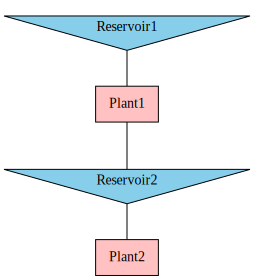

In [2]:
#Create a standard ShopSession
shop=ShopSession()

#Build a simple model with two reservoirs, two plants, and 6 generators.
build_model(shop)

#Display topology to the screen
display(shop.model.build_connection_tree())

## Generating "observed" input data
To get reasonable "historical" data for reservoir state and unit production or discharge, a standard optimization run is performed before the inflow simulation. It is not necessary to perform any optimization before running a simulation if all input data is available form a historical database or similar.

In [3]:
#Run an optimizatio
shop.start_sim([],3)    
shop.set_code("incremental",[])
shop.start_sim([],3)    

The optimization run has provided optimized results for [reservoir volume](reservoir:storage) and [](generator:discharge) and [](generator:production) for each [](generator). Each reservoir must have specified either a [](reservoir:sim_volume_schedule) or [](reservoir:sim_level_schedule) before an inflow simulation can be carried out. This is generated in the loop below, where a random inflow deviation is drawn for each hour and added to the optimized reservoir volume.

In [4]:
inflow_deviation = {}
np.random.seed(123)
for rsv in shop.model.reservoir:
    v_max = rsv.max_vol.get()
    vol = rsv.storage.get()
    
    # Draw a random inflow deviation between 0 and 20 m3/s for each time step
    random_inflow = 20*np.random.rand(len(vol)-1)
    inflow_deviation[rsv.get_name()] = random_inflow
    
    accumulated_inflow_deviation = random_inflow.cumsum()
    
    # The "observed" volume of the reservoirs is set to the optimized volumes plus the random accumulated inflow increase
    vol_schedule = vol.copy()
    for t in range(1, len(vol)):
        vol_schedule.values[t] += accumulated_inflow_deviation[t-1]*3600*1e-6
        
    rsv.sim_volume_schedule.set(vol_schedule)

## Inflow simulation based on generator discharge
An inflow simulation can then be performed with the [start shopsim command](start_shopsim) with the option "inflow". In addition, the generator discharge found in the earlier optimization run is used as input to the simulation by specifying the "gen_m3s_result" option. The output time resolution of the simulator is set to 60 seconds, which will average the calculated simulator output attributes over three internal time steps (20 seconds long). Note that the attribute [](reservoir:sim_inflow_flag) can be set on each reservoir to turn on and off inflow calculation per input time step. If no flag is given, or if the flag is 1, inflow will be calculated for the reservoir.

In [5]:
# Run an inflow simulation based on the optimized discharge levels for each generator
shop.start_shopsim(["inflow", "gen_m3s_result"], 60)

The figure below shows that the simulated reservoir levels ([](reservoir:sim_head)) deviate from the reservoir levels from the optimization ([](reservoir:head)). This is expected since a random volume deviation was added before simulating.

In [6]:
for rsv in shop.model.reservoir:
    name = rsv.get_name()
    sim_level = rsv.sim_head.get()
    opt_level = rsv.head.get()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=opt_level.index, y=opt_level.values, name="optimized"))
    fig.add_trace(go.Scatter(x=sim_level.index, y=sim_level.values, name="simulated", line=dict(dash='dash')))
    fig.update_layout(xaxis_title="Time", yaxis_title="Level [masl]",title=f"Reservoir levels: {name}")
    fig.show()

The attribute [](reservoir:sim_inflow) holds the calculated inflow from the simulation. The figure below compares this to the original input [](reservoir:inflow) used in the optimization run and the random inflow that was generated to create new reservoir trajectories. The simulated inflow is identical to the generated inflow, which is expected since the discharge of all generators are known before the simulation.

In [7]:
for rsv in shop.model.reservoir:
    name = rsv.get_name()
    sim_inflow = rsv.sim_inflow.get()
    original_inflow = rsv.inflow.get()
    
    generated_inflow = inflow_deviation[name] + original_inflow
    generated_inflow.loc[sim_inflow.index[-1]] = generated_inflow.values[-1]
    generated_inflow = generated_inflow.resample("1min").ffill()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=original_inflow.index, y=original_inflow.values, name="used in optimization"))
    fig.add_trace(go.Scatter(x=generated_inflow.index, y=generated_inflow.values, name="generated"))
    fig.add_trace(go.Scatter(x=sim_inflow.index, y=sim_inflow.values, name="simulated", line=dict(dash='dash',color="black")))
    fig.update_layout(xaxis_title="Time", yaxis_title="Flow [m3/s]",title=f"Inflow: {name}")
    fig.show()

## Inflow simulation based on generator production
The simulated inflow matched the generated inflow perfectly when the generator discharge was fixed before simulating. A second inflow calculation is now performed where a production plan is set for each generator instead of a discharge plan. The production is again based on the earlier optimization run, which can be specified by using the option "gen_mw_result" instead of "gen_m3s_result".

In [8]:
# Run an inflow simulation based on the optimized production levels for each generator
shop.start_shopsim(["inflow", "gen_mw_result"], 60)

# Plot simulated inflow
for rsv in shop.model.reservoir:
    name = rsv.get_name()
    sim_inflow = rsv.sim_inflow.get()
    original_inflow = rsv.inflow.get()
    
    generated_inflow = inflow_deviation[name] + original_inflow
    generated_inflow.loc[sim_inflow.index[-1]] = generated_inflow.values[-1]
    generated_inflow = generated_inflow.resample("1min").ffill()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=original_inflow.index, y=original_inflow.values, name="used in optimization"))
    fig.add_trace(go.Scatter(x=generated_inflow.index, y=generated_inflow.values, name="generated"))
    fig.add_trace(go.Scatter(x=sim_inflow.index, y=sim_inflow.values, name="simulated", line=dict(dash='dash',color="black")))
    fig.update_layout(xaxis_title="Time", yaxis_title="Flow [m3/s]",title=f"Inflow: {name}")
    fig.show()

The simulated inflow is now slightly different from the generated inflow that was used to create the reservoir schedules. This is because the simulated discharge of each generator now depends on the simulated reservoir levels. To keep the simulated production of each generator identical to the input production plan, the discharge has to deviate from the optimized discharge since the simulated reservoir levels are different from the optimized ones. In some cases this can result in negative simulated inflow since water has to vanish to meet the input reservoir trajectory. Negative inflow is not uncommon in inflow calculations like this, especially if there are inaccuracies in the measured historical reservoir levels.